# The Discrete Choice Cake Eating Problem
### by [Jason DeBacker](http://jasondebacker.com), June 2019
This Jupyter notebook illustrates how to solve the stochastic discerete cake eating problem using value function iteration (VFI).


## The Problem:

$$V(w, \varepsilon)=max\left\{V^{0}(w, \varepsilon), V^{1}(w, \varepsilon)\right\}, \forall w\in[0,\bar{w}]$$

where:

$$V^{0}(w, \varepsilon) = \beta E_{\varepsilon' |\varepsilon}V(\rho w,\varepsilon')$$

and

$$V^{1}(w, \varepsilon) = \varepsilon u(w)$$

The unknowns in this system are functions: The value function, $V(w, \varepsilon)$, and the policy function, $z(w,\varepsilon)\in \{0, 1\}, \forall w, \varepsilon$.

## The Solution:

We'll solve this problem with value function iteration (VFI).  With this method, we'll use an iterative procedure to converge to a fixed point in function space, the true value function, $V(w)$.  

The computational algorithm for VFI is as follows:

1. Create a discrete grid of the state variables, $w$ and $\varepsilon$
2. Make an initial guess at the value function, $V_{0}(w, \varepsilon)$
    * This will be a value for each point in the state space - the number of points is equal to the number of points in the $w$-grid times the number of points in the $\varepsilon$ grid.
3. Perform the operation:
$$TV(w) = \max\left\{\varepsilon u(w), \beta E_{\varepsilon'|\varepsilon} V_{0}(\rho w, \varepsilon')\right\}$$
4. Update the guess at the value function: $V_{1}(w) = TV(w)$
5. Repeat this process:
$$V_{i+1} \ (w) = TV(w) = \max\left\{\varepsilon u(w), \beta E_{\varepsilon'|\varepsilon} V_{i}(\rho w, \varepsilon')\right\}$$
6. Stop when, $|V_{i+1} \ (w)-V_{i}(w)|<\varepsilon$, where $\varepsilon$ is a small number.


In [14]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# to print plots inline
%matplotlib inline

## Step 1: Set parameters and create grid for state space

Prference Parameters:
* $\beta$ = rate of time preference
* $\sigma$ = coefficient of relative risk aversion (if $\sigma = 1$, $u(c)=log(c)$), parameter describes the curvature of the utility function
* Taste shock, $ln(\varepsilon_{t+1} \ ) = (1-\rho_{\varepsilon})\mu_{\varepsilon} + \rho_{\varepsilon} ln(\varepsilon_{t}) + v_{t}$, $v_{t}\sim (0, \sigma_{v})$
 * $\mu_{\varepsilon}$ = mean of taste shocks
 * $\rho_{\varepsilon}$ = persistence of taste shocks
 * $\sigma_{\varepsilon}$ = standard deviation of taste shocks

In [15]:
# Declare parameters
# Preference parameters
beta = 0.95
sigma = 1.0
# Taste shock parameters: AR(1) process: ln(epsilon_{t+1}) = (1 - rho) * mu_eps + rho_eps * ln(epsilon_{t}) + v_t
# v_t ~ N(0, sigma_v)
size_eps = 4  # number of grid points in epsilon-space
mu_eps = 0
rho_eps = 0.5
sigma_eps = 0.2  # std of eps = sigma_u /  sqrt(1 - rho)
sigma_v = sigma_eps * np.sqrt(1 - rho_eps)

# Cake growth rate (storage technology)
R = 0.95


'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
ub_w      = scalar, upper bound of cake grid 
size_w    = integer, number of grid points in cake state space
w_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
ub_w = 10.0 
size_w = 50  # Number of grid points
w_grid_rev = np.empty(size_w)
for t in range(size_w):
    w_grid_rev[t] = (R ** t) * ub_w  # note how construct so don't have to interpolate
w_grid = w_grid_rev[::-1]  # order smallest to largest
 
'''
Create grid of taste shocks
'''
import ar1_approx as ar1
ln_eps_grid, pi_t = ar1.addacooper(size_eps, mu_eps, rho_eps, sigma_v)
eps_grid = np.exp(ln_eps_grid)
pi = np.transpose(pi_t)

'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=w-w')
U        = matrix, current period utility value for all possible
           choices of w and w' (rows are w, columns w')
------------------------------------------------------------------------
'''
C = np.zeros((size_eps, size_w)) 
for i in range(size_eps): # loop over epsilon
    for j in range(size_w): # loop over w
        C[i, j] = eps_grid[i] * w_grid[j]

if sigma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - sigma)) / (1 - sigma)

In [16]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol       = scalar, tolerance required for value function to converge
VFdist      = scalar, distance between last two value functions
VFmaxiter   = integer, maximum number of iterations for value function
V           = matrix, the value functions at each iteration
TV          = matrix, the value function after applying the Bellman operator
PF_discrete = matrix, matrix of policy function: eat=1, not eat=0 
Vstore      = array, stores V at each iteration 
VFiter      = integer, current iteration number
EV          = scalar, expected value function for a given state
U_eat       = matrix, utility from eating cake now
Vwait       = matrix, value of waiting to eat the cake
VF          = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 3000 
V = np.zeros((size_eps, size_w)) # initial guess at value function
TV = np.zeros((size_eps, size_w))
PF_discrete = np.zeros((size_eps, size_w))
Vmat = np.zeros((size_w, size_w)) # initialize Vmat matrix
Vstore = np.zeros((size_eps, size_w, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_eps): # loop over epsilon
        for j in range(size_w): # loop over w
            EV = 0
            for ii in range(size_eps):  # loop over epsilon'
                EV += pi[i, ii] * V[ii, max(j - 1, 0)]   # note can move one space because of how we constructed grid
            U_eat = U[i, j]
            Vwait = beta * EV 
            TV[i, j] = max(U_eat, Vwait)
            PF_discrete[i, j] = U_eat >= Vwait  # = 1 if eat cake
            
    Vstore[:, :, VFiter] = TV # store value function at each iteration for graphing later 
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 3


In [17]:
'''
------------------------------------------------------------------------
Find threshold policy functions   
------------------------------------------------------------------------
'''
threshold_eps = np.zeros(size_w)
for j in range(size_w):
    threshold_eps[j] = eps_grid[np.argmax(PF_discrete[:, j],axis=0)]

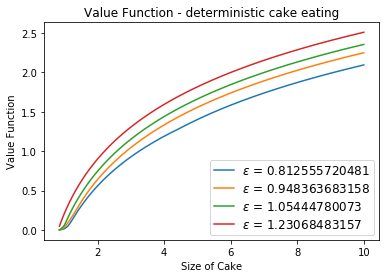

In [12]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], VF[0, 1:], label='$\epsilon$ = ' + str(eps_grid[0]))
ax.plot(w_grid[1:], VF[1, 1:], label='$\epsilon$ = ' + str(eps_grid[1]))
ax.plot(w_grid[1:], VF[2, 1:], label='$\epsilon$ = ' + str(eps_grid[2]))
ax.plot(w_grid[1:], VF[3, 1:], label='$\epsilon$ = ' + str(eps_grid[3]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

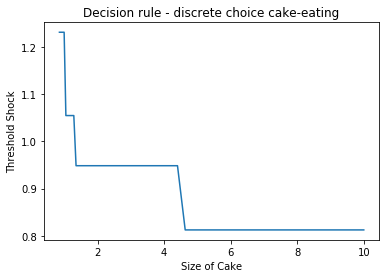

In [13]:
# Plot threshold
plt.figure()
plt.plot(w_grid[1:], threshold_eps[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Threshold Shock')
plt.title('Decision rule - discrete choice cake-eating')
plt.show()